In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv('/content/The_Cancer_data_1500_V2.csv')

# Display first few rows
print(df.head())


   Age  Gender        BMI  Smoking  GeneticRisk  PhysicalActivity  \
0   58       1  16.085313        0            1          8.146251   
1   71       0  30.828784        0            1          9.361630   
2   48       1  38.785084        0            2          5.135179   
3   34       0  30.040296        0            0          9.502792   
4   62       1  35.479721        0            0          5.356890   

   AlcoholIntake  CancerHistory  Diagnosis  
0       4.148219              1          1  
1       3.519683              0          0  
2       4.728368              0          1  
3       2.044636              0          0  
4       3.309849              0          1  


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Select features and target
X = df[['Age', 'Gender', 'BMI', 'Smoking', 'GeneticRisk',
        'PhysicalActivity', 'AlcoholIntake', 'CancerHistory']]
y = df['Diagnosis']  # Target: 0 or 1

# Split into train and test sets (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scale numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Train Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Train Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Train XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:49:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def evaluate_model(model, name):
    y_pred = model.predict(X_test)
    print(f"\n{name} Evaluation")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

evaluate_model(lr, "Logistic Regression")
evaluate_model(rf, "Random Forest")
evaluate_model(xgb, "XGBoost")



Logistic Regression Evaluation
Accuracy: 0.8433333333333334
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.88      0.88       189
           1       0.80      0.77      0.79       111

    accuracy                           0.84       300
   macro avg       0.83      0.83      0.83       300
weighted avg       0.84      0.84      0.84       300

Confusion Matrix:
 [[167  22]
 [ 25  86]]

Random Forest Evaluation
Accuracy: 0.9466666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.96       189
           1       0.97      0.88      0.92       111

    accuracy                           0.95       300
   macro avg       0.95      0.93      0.94       300
weighted avg       0.95      0.95      0.95       300

Confusion Matrix:
 [[186   3]
 [ 13  98]]

XGBoost Evaluation
Accuracy: 0.9466666666666667
Classification Report:
               precision  

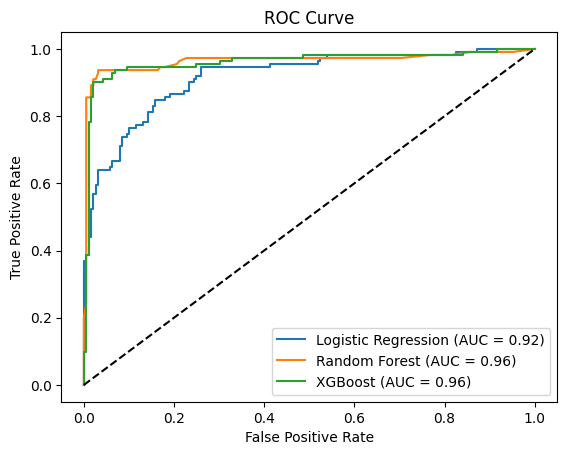

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def plot_roc(model, name):
    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    auc = roc_auc_score(y_test, y_probs)

    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

plt.figure()
plot_roc(lr, 'Logistic Regression')
plot_roc(rf, 'Random Forest')
plot_roc(xgb, 'XGBoost')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [ ]:
from sklearn.ensemble import VotingClassifier

# Create base models
logistic = LogisticRegression()
random_forest = RandomForestClassifier()
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Create ensemble
voting_clf = VotingClassifier(
    estimators=[('lr', logistic), ('rf', random_forest), ('xgb', xgb)],
    voting='soft'  # use 'hard' for majority class vote
)

# Train ensemble
voting_clf.fit(X_train, y_train)

# Evaluate ensemble
from sklearn.metrics import accuracy_score
y_pred = voting_clf.predict(X_test)
print("Ensemble Accuracy:", accuracy_score(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:56:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Ensemble Accuracy: 0.9466666666666667


In [ ]:
from sklearn.ensemble import StackingClassifier

# Define base learners
base_learners = [
    ('lr', LogisticRegression()),
    ('rf', RandomForestClassifier()),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
]

# Define meta-learner
meta_model = LogisticRegression()

# Create stacking ensemble
stacked_model = StackingClassifier(estimators=base_learners, final_estimator=meta_model)
stacked_model.fit(X_train, y_train)

# Evaluate
y_pred = stacked_model.predict(X_test)
print("Stacked Model Accuracy:", accuracy_score(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:57:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:57:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:57:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:57:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:57:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Stacked Model Accuracy: 0.95


In [ ]:
import joblib

# Save the stacked model
joblib.dump(stacked_model, "cancer_prediction_model.pkl")


['cancer_prediction_model.pkl']

In [ ]:
# Load model
model = joblib.load("cancer_prediction_model.pkl")

# Example prediction
sample = [[48, 1, 28.5, 0, 1, 6.0, 3.2, 0]]  # Replace with actual values
sample_scaled = scaler.transform(sample)
print("Prediction:", model.predict(sample_scaled))


Prediction: [1]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
# Import the files object from google.colab to enable file downloads in Colab
from google.colab import files

files.download('cancer_prediction_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>